In [1]:
from theano.sandbox import cuda
import os, sys
current_dir = os.getcwd()
lesson_dir = current_dir
data_dir = current_dir + '/data/fish/'

from utils import *
%matplotlib inline

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
batch_size = 64
batches = get_batches(data_dir+'train', batch_size=batch_size)
val_batches = get_batches(data_dir+'valid', batch_size=batch_size*2, shuffle=False)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [3]:
print(type(val_batches))

<class 'keras.preprocessing.image.DirectoryIterator'>


In [4]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(data_dir)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [5]:
# Using the get_classes command, we retrieved
print(type(val_classes))
print(val_classes[0])
print(type(val_labels))
print(val_labels[0])
print(type(val_filenames))
print(val_filenames[0])
print(trn_labels[0])
# print(test_filenames[0])

<type 'numpy.ndarray'>
0
<type 'numpy.ndarray'>
[ 1.  0.  0.  0.  0.  0.  0.  0.]
<type 'list'>
ALB/img_07418.jpg
[ 1.  0.  0.  0.  0.  0.  0.  0.]


In [6]:
# We split the filenames by the '/' seperator and return the last element of the split sequence.
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [7]:
print(raw_test_filenames[0])

img_06237.jpg


In [8]:
# This function accepts an integer value(which is supposed to be the output dimension)
# def vgg_ft_bn(out_dim):
#     # A VggBN object is instantiated
#     vgg = Vgg16BN()
#     # Finetuning is done on the original VggBN model 
#     vgg.ft(out_dim)
#     model = vgg.model
#     return model

# def ft(self, num):
#     # self refers to the currently initialized VggBN object
#     model = self.model
#     # The last layer from the model(1000 categories) is removed
#     model.pop()
#     # The layers are no longer set to be trainable 
#     for layer in model.layers:
#         layer.trainable = False
#     # Finally, a final dense layer with the output dimensionality mentioned in vgg_ft_bn
#     # is given the output value for the added layer.
#     model.add(Dense(num, activation='softmax'))
#     # The new model is then compiled
#     self.compile

In [9]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

In [10]:
# Now it is clear that the change made in the above code-block is
# apparent in the model.
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [28]:
# Now we retrive the image data in the form of arrays that are
# accepted by our VGG model.
trn = get_data(data_dir + 'train')
val = get_data(data_dir + 'valid')
test = get_data(data_dir + 'test')

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [34]:
# Obviously we get our data in the form of a numpy array.
print(type(val))
# Whose shape is (500, 3, 224, 224)
print(val.shape)
# Each of the 500 elements of the array is of the shape
# (3,224,224) corresponding to the number of color channels and the rows * columns of the image
print(val[499].shape)

<type 'numpy.ndarray'>
(500, 3, 224, 224)
(3, 224, 224)


In [42]:
save_array(data_dir+'results/trn3.dat', trn)
save_array(data_dir+'results/val3.dat', val)
save_array(data_dir+'results/test3.dat', test)

In [11]:
trn = load_array(data_dir+'results/trn3.dat')
val = load_array(data_dir+'results/val3.dat')
test = load_array(data_dir+'results/test3.dat')

In [11]:
print(type(val))
print(val.shape)
print(val[499].shape)

<type 'numpy.ndarray'>
(500, 3, 224, 224)
(3, 224, 224)


In [12]:
gen = image.ImageDataGenerator()
# print(type(gen))

In [13]:
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
 768/3277 [======>.......................] - ETA: 58s - loss: 3.8770 - acc: 0.3568

KeyboardInterrupt: 

In [12]:
model.layers

In [13]:
model.layers[-1].output_shape

(None, 8)

In [54]:
model.save_weights(data_dir+'results/finetune_toSubmit.h5')

In [11]:
model.load_weights(data_dir+'results/finetune_toSubmit.h5')

In [14]:
#  Precomputing the convolutional output
conv_layers, fc_layers = split_at(model, Convolution2D)

In [15]:
# It is evident that upon splitting the model at the specified
print(conv_layers[-1].output_shape)
# Clearly, the output of the final convolutional layer should be the input of the
# first fully connected layer
print(fc_layers[0].input_shape)

(None, 512, 14, 14)
(None, 512, 14, 14)


In [16]:
conv_model = Sequential(conv_layers)

In [17]:
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

In [67]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)
conv_test_feat = conv_model.predict(test)

In [69]:
print(conv_val_feat.shape)

(500, 512, 14, 14)


In [70]:
# print(type(conv_val_feat))
# print(conv_val_feat[0])
# print(val[0])

In [71]:
save_array(data_dir+'results/conv_feat2.dat', conv_feat)
save_array(data_dir+'results/conv_val_feat2.dat', conv_val_feat)
save_array(data_dir+'results/conv_test_feat2.dat', conv_test_feat)

In [18]:
conv_feat = load_array(data_dir+'results/conv_feat2.dat')
conv_val_feat = load_array(data_dir+'results/conv_val_feat2.dat')
conv_test_feat = load_array(data_dir+'results/conv_test_feat2.dat')

In [19]:
conv_val_feat.shape

(500, 512, 14, 14)

In [20]:
fc_layers

In [21]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [22]:
p = 0.6
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
bn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_6 (MaxPooling2D)    (None, 512, 7, 7)     0           maxpooling2d_input_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_3 (BatchNormal(None, 512, 7, 7)     1024        maxpooling2d_6[0][0]             
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 512, 7, 7)     0           batchnormalization_3[0][0]       
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 25088)         0           dropout_3[0][0]                  
___________________________________________________________________________________________

In [26]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(conv_val_feat, val_labels) )

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 1s - loss: 1.1221 - acc: 0.6692 - val_loss: 1.0447 - val_acc: 0.8240
Epoch 2/3
3277/3277 [==============================] - 1s - loss: 0.3536 - acc: 0.9054 - val_loss: 0.2312 - val_acc: 0.9540
Epoch 3/3
3277/3277 [==============================] - 1s - loss: 0.1594 - acc: 0.9548 - val_loss: 0.1820 - val_acc: 0.9540


In [27]:
bn_model.optimizer.lr = 1e-4
bn_model.fit(conv_feat, trn_labels, batch_size = batch_size, nb_epoch=7, validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/7
3277/3277 [==============================] - 1s - loss: 0.1126 - acc: 0.9686 - val_loss: 0.1337 - val_acc: 0.9740
Epoch 2/7
3277/3277 [==============================] - 1s - loss: 0.0725 - acc: 0.9808 - val_loss: 0.1635 - val_acc: 0.9740
Epoch 3/7
3277/3277 [==============================] - 1s - loss: 0.0419 - acc: 0.9875 - val_loss: 0.1409 - val_acc: 0.9780
Epoch 4/7
3277/3277 [==============================] - 1s - loss: 0.0349 - acc: 0.9908 - val_loss: 0.1280 - val_acc: 0.9700
Epoch 5/7
3277/3277 [==============================] - 1s - loss: 0.0263 - acc: 0.9924 - val_loss: 0.1478 - val_acc: 0.9720
Epoch 6/7
3277/3277 [==============================] - 1s - loss: 0.0399 - acc: 0.9893 - val_loss: 0.1214 - val_acc: 0.9780
Epoch 7/7
3277/3277 [==============================] - 1s - loss: 0.0249 - acc: 0.9939 - val_loss: 0.1436 - val_acc: 0.9760


In [28]:
bn_model.save_weights(data_dir+'models/convbnS3.h5')

In [29]:
bn_model.evaluate(conv_val_feat, val_labels)

480/500 [===========================>..] - ETA: 0s

[0.1436051349369809, 0.97599999999999998]

In [19]:
bn_model.load_weights(data_dir+'models/convbnS3.h5')

In [70]:
def do_clip(arr, mx):
    return np.clip(arr, (1-mx)/7, mx)

In [32]:
predictions = bn_model.predict(conv_test_feat, batch_size=batch_size)

In [33]:
# The first 5 predictions.
for i in xrange(5):
    print(predictions[i])

[  9.9839e-01   4.1239e-04   6.2496e-05   1.5809e-05   2.6479e-04   6.4400e-04   8.2490e-05
   1.2597e-04]
[ 0.2831  0.1714  0.0096  0.0055  0.0071  0.5084  0.0023  0.0127]
[  4.7665e-02   8.9427e-05   1.0562e-03   4.8214e-04   9.2230e-01   1.6021e-04   2.8016e-02
   2.3433e-04]
[  9.9990e-01   9.4533e-06   6.1159e-07   2.2076e-06   6.5773e-07   1.4405e-05   1.9160e-07
   7.1559e-05]
[  9.9999e-01   2.8528e-06   2.2383e-06   1.9743e-06   1.1039e-06   1.3736e-06   7.7658e-07
   1.6486e-06]


In [34]:
subm = do_clip(predictions, 0.82)

In [37]:
print(type(subm))
print(subm[0])

<type 'numpy.ndarray'>
[ 0.82    0.0257  0.0257  0.0257  0.0257  0.0257  0.0257  0.0257]


In [47]:
submission_name = data_dir+'results/toSubmit_try.csv'

In [58]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [94]:
# reload(sys)
# sys.setdefaultencoding('utf8')
import sys

In [41]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
1,img_06893.jpg,0.283052,0.171382,0.025714,0.025714,0.025714,0.508379,0.025714,0.025714
2,img_02082.jpg,0.047665,0.025714,0.025714,0.025714,0.820000,0.025714,0.028016,0.025714
3,img_06261.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
4,img_03628.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714


In [42]:
print(type(submission))

In [48]:
submission.to_csv(submission_name, index=False, encoding='utf-8')

In [49]:
# This result placed me on the 733rd position.
FileLink(submission_name)

/home/ubuntu/nbs/data/fish/results/toSubmit_try.csv

In [23]:
# Loaded weights are convbns3.h5
# Creating Multi input architectures.
sizes = [PIL.Image.open(data_dir+'train/'+f).size for f in filenames]
# Finding unique sizes of images
id2size = list(set(sizes))

size2id = {o:i for i,o in enumerate(id2size)}

In [24]:
# The unique sizes of images
id2size
# sizes
# import collections
# collections.Counter(sizes)

[(1280, 750),
 (1244, 700),
 (1732, 974),
 (1334, 750),
 (1192, 670),
 (1280, 720),
 (1276, 718),
 (1280, 974),
 (1518, 854),
 (1280, 924)]

In [25]:
# Key:Value generation
# Size is the key : Index number is the value
size2id

{(1192, 670): 4,
 (1244, 700): 1,
 (1276, 718): 6,
 (1280, 720): 5,
 (1280, 750): 0,
 (1280, 924): 9,
 (1280, 974): 7,
 (1334, 750): 3,
 (1518, 854): 8,
 (1732, 974): 2}

In [26]:
import collections
# unordered data struct where elements are stored as keys and their counts as values
collections.Counter(sizes)

Counter({(1192, 670): 167,
         (1244, 700): 23,
         (1276, 718): 188,
         (1280, 720): 1889,
         (1280, 750): 514,
         (1280, 924): 46,
         (1280, 974): 357,
         (1334, 750): 29,
         (1518, 854): 33,
         (1732, 974): 31})

In [27]:
# One-hot encoding the sizes of images.
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [28]:
trn_sizes_orig[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [29]:
raw_val_size = [PIL.Image.open(data_dir+'valid/'+f).size for f in val_filenames]

In [30]:
raw_val_size[10]

(1192, 670)

In [31]:
# One-hot encoding the raw_val_sizes, the same as trn_sizes_orig
val_sizes = to_categorical([size2id[o] for o in raw_val_size])

In [32]:
# We confirm that the val_sizes variable has one-hot encoded our raw_val_size
# as defined by size2id
val_sizes[10]

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [33]:
# I need to learn this better
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

In [30]:
# This is the normalized data
print(trn_sizes[1])
print(val_sizes[1])

[-0.4313 -0.0841 -0.0977 -0.0945 -0.2317 -0.1666 -0.2467 -0.3497 -0.1009 -0.1193]
[-0.4313 -0.0841 -0.0977 -0.0945  0.7683 -1.1666 -0.2467 -0.3497 -0.1009 -0.1193]


In [34]:
p = 0.6
inp = Input(conv_layers[-1].output_shape[1:])

In [35]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [33]:
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

# The functional API is utilized to make a new architecture.
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = merge([x, bn_inp], 'concat')
x = Dense(8, activation='softmax')(x)

In [34]:
# This model basically takes in the input from the output of the last
# convolutional layer and the metadata regarding the image sizes.
model = Model([inp, sz_inp], x)

In [35]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 14, 14)   0                                            
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 512, 7, 7)     0           input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_7 (BatchNormal(None, 512, 7, 7)     1024        maxpooling2d_7[0][0]             
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 512, 7, 7)     0           batchnormalization_7[0][0]       
___________________________________________________________________________________________

In [40]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# conv_feat from the prv model and trn_sizes is the normalized metadata stuff.
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 1.1229 - acc: 0.6668 - val_loss: 0.8044 - val_acc: 0.8480
Epoch 2/3
3277/3277 [==============================] - 1s - loss: 0.3118 - acc: 0.9124 - val_loss: 0.3227 - val_acc: 0.9360
Epoch 3/3
3277/3277 [==============================] - 1s - loss: 0.1417 - acc: 0.9640 - val_loss: 0.1841 - val_acc: 0.9560


In [42]:
model.optimizer.lr = 1e-4
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=8, validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/8
3277/3277 [==============================] - 2s - loss: 0.1003 - acc: 0.9753 - val_loss: 0.1561 - val_acc: 0.9680
Epoch 2/8
3277/3277 [==============================] - 1s - loss: 0.1033 - acc: 0.9673 - val_loss: 0.1543 - val_acc: 0.9700
Epoch 3/8
3277/3277 [==============================] - 1s - loss: 0.0669 - acc: 0.9805 - val_loss: 0.1547 - val_acc: 0.9720
Epoch 4/8
3277/3277 [==============================] - 1s - loss: 0.0524 - acc: 0.9847 - val_loss: 0.1418 - val_acc: 0.9760
Epoch 5/8
3277/3277 [==============================] - 1s - loss: 0.0355 - acc: 0.9887 - val_loss: 0.1482 - val_acc: 0.9700
Epoch 6/8
3277/3277 [==============================] - 1s - loss: 0.0397 - acc: 0.9887 - val_loss: 0.1277 - val_acc: 0.9720
Epoch 7/8
3277/3277 [==============================] - 1s - loss: 0.0400 - acc: 0.9884 - val_loss: 0.1749 - val_acc: 0.9660
Epoch 8/8
3277/3277 [==============================] - 1s - loss: 0.0340 - acc: 0.989

In [43]:
# Saved model with metadata predictions.
model.save_weights(data_dir+'models/metadatamodeldos.h5')

In [36]:
# Bounding boxes model
import ujson as json

In [37]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [38]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}annos/{}_labels.json'.format(data_dir, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [44]:
bb_json['img_07566.jpg']

{u'class': u'rect',
 u'height': 81.68873634345266,
 u'width': 149.06089002877445,
 u'x': 165.06177652903835,
 u'y': 368.0203895060702}

In [40]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [42]:
# Dimensions of an empty bounding box
empty_bbox = {'height':0., 'width':0., 'x': 0., 'y': 0.}

In [45]:
# For images without annotations, we add an empty bounding box.
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [46]:
# Parameters of a bounding box
bb_params = ['height', 'width', 'x', 'y']

# Converting the bounding box dictionary to an array.
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [47]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, sizes)]).astype(np.float32)

In [49]:
print(trn_bbox[0])

[  19.5795   29.5077   61.5091  135.2092]


In [57]:
def create_rect(bb, color='g'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=2)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

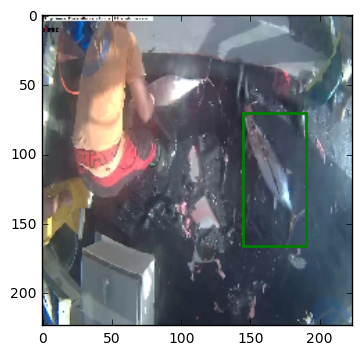

In [58]:
show_bb(200)

In [59]:
# Training a model that is multi output (the bounding box + the classification)
p = 0.6

In [61]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [62]:
# Since there are multiple outputs the model needs to be provided with an array of the 2 types of outputs
# The loss function for each output also needs to be specified
# The weight for the bounding box loss function needs to be weighed down by 1000X since the scale of the cross-entropy loss and MSE are different

model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'], loss_weights=[0.001, 1.])

In [63]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 6.1942 - bb_loss: 5038.5020 - class_loss: 1.1557 - bb_acc: 0.4132 - class_acc: 0.6594 - val_loss: 5.1667 - val_bb_loss: 4352.4215 - val_class_loss: 0.8143 - val_bb_acc: 0.4940 - val_class_acc: 0.8720
Epoch 2/3
3277/3277 [==============================] - 1s - loss: 5.0760 - bb_loss: 4768.3744 - class_loss: 0.3076 - bb_acc: 0.5005 - class_acc: 0.9118 - val_loss: 4.3628 - val_bb_loss: 4059.2405 - val_class_loss: 0.3036 - val_bb_acc: 0.5420 - val_class_acc: 0.9260
Epoch 3/3
3277/3277 [==============================] - 1s - loss: 4.4861 - bb_loss: 4310.7428 - class_loss: 0.1754 - bb_acc: 0.5465 - class_acc: 0.9487 - val_loss: 3.8569 - val_bb_loss: 3707.1388 - val_class_loss: 0.1497 - val_bb_acc: 0.5680 - val_class_acc: 0.9620


In [64]:
model.optimizer.lr = 1e-5
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 2s - loss: 3.7849 - bb_loss: 3673.4477 - class_loss: 0.1115 - bb_acc: 0.5719 - class_acc: 0.9643 - val_loss: 3.3640 - val_bb_loss: 3215.4265 - val_class_loss: 0.1486 - val_bb_acc: 0.5900 - val_class_acc: 0.9660
Epoch 2/10
3277/3277 [==============================] - 1s - loss: 2.9802 - bb_loss: 2909.7259 - class_loss: 0.0705 - bb_acc: 0.6125 - class_acc: 0.9820 - val_loss: 2.7606 - val_bb_loss: 2606.9772 - val_class_loss: 0.1537 - val_bb_acc: 0.6120 - val_class_acc: 0.9640
Epoch 3/10
3277/3277 [==============================] - 1s - loss: 2.1544 - bb_loss: 2098.5716 - class_loss: 0.0558 - bb_acc: 0.6494 - class_acc: 0.9835 - val_loss: 2.0343 - val_bb_loss: 1887.6010 - val_class_loss: 0.1467 - val_bb_acc: 0.6140 - val_class_acc: 0.9660
Epoch 4/10
3277/3277 [==============================] - 1s - loss: 1.3855 - bb_loss: 1328.6699 - class_loss: 0.0568 - bb_acc: 0.6857 - class_acc: 0.9832

In [82]:
# The model improved. It's time to test that model to predict the validation data.
pred = model.predict(conv_val_feat[0:5])

In [83]:
type(pred)

list

In [84]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    # returns the current axis
    ax=plt.gca()
    # On the current axis, the predicted bb is plotted
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    # On the current axis the original(annotated) bb is plotted
    ax.add_patch(create_rect(bb))

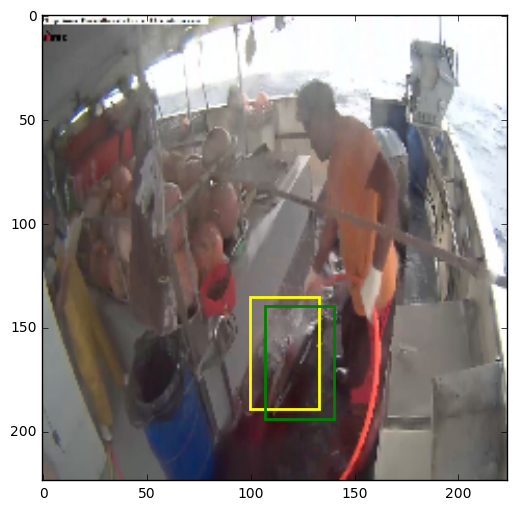

In [85]:
# The yellow is the predicted bounding box and the green is the actual bounding box.
show_bb_pred(0)

In [86]:
# Need to read up a bit more on DIS
model.evaluate(conv_val_feat, [val_bbox, val_labels])

500/500 [==============================] - 0s     


[0.40388955152034761,
 257.46480102539061,
 0.14642473967454861,
 0.8179999990463257,
 0.97399999999999998]

In [81]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 0.2414 - bb_loss: 221.7832 - class_loss: 0.0196 - bb_acc: 0.7901 - class_acc: 0.9948 - val_loss: 0.4037 - val_bb_loss: 273.2430 - val_class_loss: 0.1305 - val_bb_acc: 0.8280 - val_class_acc: 0.9780
Epoch 2/3
3277/3277 [==============================] - 1s - loss: 0.2153 - bb_loss: 200.5597 - class_loss: 0.0148 - bb_acc: 0.7958 - class_acc: 0.9966 - val_loss: 0.4115 - val_bb_loss: 262.0390 - val_class_loss: 0.1495 - val_bb_acc: 0.8200 - val_class_acc: 0.9760
Epoch 3/3
3277/3277 [==============================] - 1s - loss: 0.2151 - bb_loss: 199.7516 - class_loss: 0.0154 - bb_acc: 0.8001 - class_acc: 0.9966 - val_loss: 0.4039 - val_bb_loss: 257.4648 - val_class_loss: 0.1464 - val_bb_acc: 0.8180 - val_class_acc: 0.9740


In [87]:
model.save_weights(data_dir+'models/bb_weights.h5')

In [88]:
model.load_weights(data_dir+'models/bb_weights.h5')

In [89]:
# We then make predictions on the test set.
predictions = model.predict(conv_test_feat, batch_size=batch_size)

In [99]:
# These are the predictions
print(predictions[0][250])
print(predictions[1][250])

[  34.6565   37.0298   62.7986  120.9565]
[  5.8730e-05   2.5594e-02   7.2113e-04   4.1211e-02   2.1602e-05   2.1394e-02   1.6675e-02
   8.9432e-01]


In [103]:
# Defined a function that plots the bounding box on a test image.
def test_bb_pred(i):
    bb_pred = predictions[0][i]
    plt.figure(figsize=(6,6))
    plot(test[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))

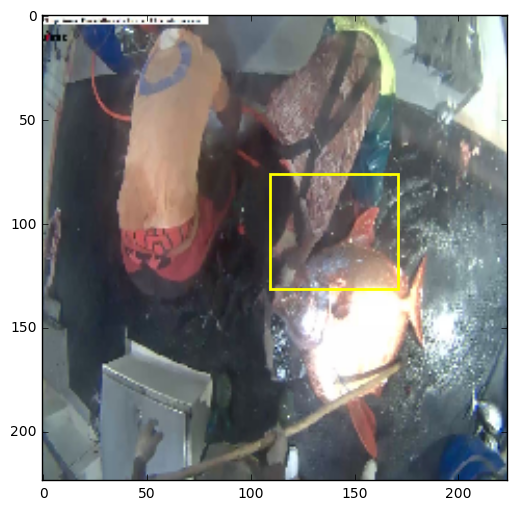

In [136]:
test_bb_pred(205)

In [105]:
# First 5 predictions on the test set.
for i in xrange(5):
    print(predictions[1][i])

[  9.9898e-01   4.6527e-04   9.0765e-06   1.2352e-04   2.3108e-06   3.4032e-04   5.8677e-06
   7.3724e-05]
[  9.1453e-01   6.2817e-03   2.7648e-03   1.5495e-03   5.1667e-04   7.0511e-02   2.6326e-03
   1.2132e-03]
[  9.5961e-01   3.0424e-05   1.0632e-04   1.0509e-04   3.1907e-02   2.3602e-04   7.7853e-03
   2.1567e-04]
[  9.9963e-01   5.0886e-06   7.7445e-07   4.0617e-06   5.4590e-07   1.4456e-05   1.2831e-06
   3.4548e-04]
[  9.9997e-01   3.7850e-06   1.6121e-06   3.9223e-06   8.1618e-06   2.0064e-06   1.1889e-06
   8.2192e-06]


In [118]:
# clipping values
def do_another_clip(arr, mx):
    return np.clip(arr, (1-mx)/7, mx)

In [119]:
submission = do_another_clip(predictions[1], 0.82)

In [124]:
len(submission)

1000

In [135]:
# Below are the clipped predictions between 200 & 208 indices
for i in range(200,208):
    print(submission[i])

[ 0.82    0.0257  0.0257  0.0257  0.0257  0.0257  0.0257  0.0257]
[ 0.82    0.0257  0.0257  0.0257  0.0257  0.0257  0.0257  0.0257]
[ 0.82    0.0257  0.0257  0.0257  0.0257  0.0257  0.0257  0.0257]
[ 0.82    0.0257  0.0257  0.0257  0.0257  0.0257  0.0257  0.0257]
[ 0.82    0.0257  0.0257  0.0257  0.0257  0.0257  0.0257  0.0257]
[ 0.4939  0.0257  0.0257  0.4156  0.0257  0.0538  0.0257  0.0257]
[ 0.0257  0.0257  0.0257  0.0257  0.82    0.0257  0.0257  0.0257]
[ 0.0257  0.4775  0.0257  0.0257  0.0257  0.0257  0.0257  0.5048]


In [137]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [139]:
table = pd.DataFrame(submission, columns=classes)
table.insert(0,'image', raw_test_filenames)
table.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,0.82,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
1,img_06893.jpg,0.82,0.025714,0.025714,0.025714,0.025714,0.070511,0.025714,0.025714
2,img_02082.jpg,0.82,0.025714,0.025714,0.025714,0.031907,0.025714,0.025714,0.025714
3,img_06261.jpg,0.82,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
4,img_03628.jpg,0.82,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714


In [141]:
table.to_csv(data_dir+'results/toSubmit_bbox.csv', index=False, encoding='utf-8')

In [142]:
# This submission placed me 626th out of 1800 participants
FileLink(data_dir+'results/toSubmit_bbox.csv')

/home/ubuntu/nbs/data/fish/results/toSubmit_bbox.csv

In [143]:
# Deleting the previously stored trn, val and test images
del trn
del val
del test

In [144]:
# Creating models that accepts images with large sizes to see if classification is more accurate.
# Image size is (height, width)
trn = get_data(data_dir+'train', (360,640))
val = get_data(data_dir+'valid', (360,640))
test = get_data(data_dir+'test', (360, 640))

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


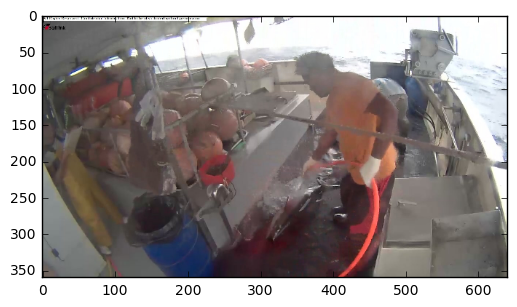

In [147]:
# plot(trn[0])
# A larger dimensional image.
plot(val[0])
# plot(test[0])


In [149]:
save_array(data_dir+'results/large_image_trn.dat', trn)
save_array(data_dir+'results/large_image_val.dat', val)
save_array(data_dir+'results/large_image_tst.dat', test)

In [150]:
trn = load_array(data_dir+'results/large_image_trn.dat')
val = load_array(data_dir+'results/large_image_val.dat')
test = load_array(data_dir+'results/large_image_tst.dat')

In [153]:
# (3277 images, 3 channels, 360 height, 640 width )
trn.shape

(3277, 3, 360, 640)

In [161]:
# Instantiating a new vgg model
vgg640 = Vgg16BN((360,640)).model

In [162]:
vgg640.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 360, 640)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 362, 642)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 360, 640)  1792        zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 362, 642)  0           convolution2d_27[0][0]           
___________________________________________________________________________________________

In [163]:
vgg640.pop()
# input_shape = (None, 3, 360, 640)
# output_shape = (None, 512, 22, 40)
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [165]:
# We pre-compute the convolutional output of the vgg16BN model
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

1000/1000 [==============================] - 127s   


In [166]:
save_array(data_dir+'results/conv_val_lrg_img.dat', conv_val_feat)
save_array(data_dir+'results/conv_trn_lrg_img.dat', conv_trn_feat)
save_array(data_dir+'results/conv_test_lrg_img.dat', conv_test_feat)

In [167]:
conv_val_feat = load_array(data_dir+'results/conv_val_lrg_img.dat')
conv_trn_feat = load_array(data_dir+'results/conv_trn_lrg_img.dat')
conv_test_feat = load_array(data_dir+'results/conv_test_lrg_img.dat')

In [168]:
# Fully Convolutional Net
# There is no return value in what would be the split half of the model.
# Since there isn't, it is replaced by an _
conv_layers,_ = split_at(vgg640, Convolution2D)

In [172]:
nf = 128; p=0

In [179]:
def get_lrg_layers():
    return[
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(8,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [180]:
lrg_model = Sequential(get_lrg_layers())

th


In [181]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_16 (BatchNorma(None, 512, 22, 40)   1024        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_45 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_16[0][0]      
____________________________________________________________________________________________________
batchnormalization_17 (BatchNorma(None, 128, 22, 40)   256         convolution2d_45[0][0]           
____________________________________________________________________________________________________
maxpooling2d_22 (MaxPooling2D)   (None, 128, 11, 20)   0           batchnormalization_17[0][0]      
___________________________________________________________________________________________

In [182]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [183]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 14s - loss: 0.6488 - acc: 0.7952 - val_loss: 2.0391 - val_acc: 0.6500
Epoch 2/2
3277/3277 [==============================] - 14s - loss: 0.1218 - acc: 0.9680 - val_loss: 0.6029 - val_acc: 0.7960


In [186]:
lrg_model.optimizer = 1e-5
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 14s - loss: 0.0184 - acc: 0.9948 - val_loss: 0.2843 - val_acc: 0.9580
Epoch 2/6
3277/3277 [==============================] - 14s - loss: 0.0133 - acc: 0.9966 - val_loss: 0.2771 - val_acc: 0.9240
Epoch 3/6
3277/3277 [==============================] - 14s - loss: 0.0171 - acc: 0.9951 - val_loss: 0.3175 - val_acc: 0.9460
Epoch 4/6
3277/3277 [==============================] - 14s - loss: 0.0092 - acc: 0.9985 - val_loss: 0.3339 - val_acc: 0.9480
Epoch 5/6
3277/3277 [==============================] - 14s - loss: 0.0018 - acc: 0.9997 - val_loss: 0.1962 - val_acc: 0.9700
Epoch 6/6
3277/3277 [==============================] - 14s - loss: 3.3102e-04 - acc: 1.0000 - val_loss: 0.1958 - val_acc: 0.9680


In [187]:
lrg_model.evaluate(conv_val_feat, val_labels)

500/500 [==============================] - 1s     


[0.1958407148644328, 0.96799999952316285]

In [188]:
lrg_model.save_weights(data_dir+'models/lrg_image_model.h5')

In [189]:
lrg_model.load_weights(data_dir+'models/lrg_image_model.h5')

In [190]:
# Predicting on the large model.
predictions = lrg_model.predict(conv_test_feat, batch_size=batch_size)

In [191]:
predictions[0]

array([  9.9997e-01,   1.5208e-05,   1.8579e-06,   5.8855e-07,   8.0905e-06,   2.1774e-06,
         4.3728e-08,   3.9808e-07], dtype=float32)

In [192]:
def clip_tres(arr, mx):
    return np.clip(arr, (1-mx)/7, mx)

In [193]:
clipped_predictions = clip_tres(predictions, 0.82)

In [195]:
for i in range(200,208):
    print clipped_predictions[i]

[ 0.82    0.0257  0.0257  0.0257  0.0454  0.0257  0.0257  0.0257]
[ 0.5578  0.0257  0.0257  0.0257  0.4419  0.0257  0.0257  0.0257]
[ 0.82    0.0257  0.0257  0.0257  0.0257  0.0257  0.0257  0.0257]
[ 0.82    0.0257  0.0257  0.0257  0.0257  0.0257  0.0257  0.0257]
[ 0.4843  0.0257  0.0257  0.5061  0.0257  0.0257  0.0257  0.0257]
[ 0.82    0.0257  0.0257  0.0379  0.0257  0.0257  0.0257  0.0257]
[ 0.0257  0.0257  0.0257  0.0257  0.82    0.0257  0.0257  0.0257]
[ 0.0257  0.2247  0.0257  0.0257  0.0257  0.0257  0.0257  0.7666]


In [196]:
table = pd.DataFrame(clipped_predictions, columns=classes)
table.insert(0,'image', raw_test_filenames)
table.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
1,img_06893.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.130472,0.025714,0.025714
2,img_02082.jpg,0.163583,0.025714,0.025714,0.025714,0.820000,0.025714,0.025714,0.025714
3,img_06261.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
4,img_03628.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714


In [197]:
table.to_csv(data_dir+'results/toSubmit_lrg_model.csv', index=False, encoding='utf-8')

In [198]:
FileLink(data_dir+'results/toSubmit_lrg_model.csv')

/home/ubuntu/nbs/data/fish/results/toSubmit_lrg_model.csv